# Module 2 - Temporal Dynamics in the EEG Engagement Index


## Creators
- Anita Vrins 
- Caterina Ceccato
- Ethel Pruss
- Jos Prinsen


## Introduction

This module makes use of a dataset which reports on participants *EEG Engagement Index* (Pope et al., 1995) during a listening task.

The dataset is divided in two conditions: 
- **Adaptive**: Where a social robot performed a gesture when it noticed a drop in EEG Engagement
- **Random**: Where the same social robot performed a gesture at random times


The index was calculated using Welch's method, with sliding windows of 1 second and no overlap.
The original signal was approximately 5 minutes with a sampling rate of 250 Hz. The EEG Engagement dataset contains approximately 500 timepoints per condition over 2 conditions for 39 participants. 

## Contents:

- **Section 1: What are the temporal signatures of the signal?**
    
- **Section 2: Are the signals stationary?**
   
- **Section 3: Does autocorrelation, as measured by ACF peaks, change over time?** 

## Short summary:
This module investigates the temporal signature as well as stationarity of the EEG Engagement Index over time.

This is done by dividing the signals in half and performing variance, mean and autocorrelation testing over both halves, as well as a KPSS test.

We found that nonstationarity did not occur often, however, when it did, it was most prevalent in the Adaptive condition in the frontal regions.  


Additionally, we found that autocorrelation peaks were distributed differently between the first and second halves of the same condition. This indicates a change in temporal dynamics for the EEG Engagement Index over time. 


# Section 1: What are the temporal signatures of the signal?


### 1.1 File loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



%matplotlib inline

In [2]:

pathRandom = "C:\\Users\\anita\\OneDrive\\Bureaublad\\Anita\'s stuff II\\Tilburg university\\Brainihacks\\EngagementStudy\\CleanSetFiles\\EngagementCSV_1sec\\Random"
pathAdaptive = "C:\\Users\\anita\\OneDrive\\Bureaublad\\Anita\'s stuff II\\Tilburg university\\Brainihacks\\EngagementStudy\\CleanSetFiles\\EngagementCSV_1sec\\Adaptive"


In [4]:
#Both conditions have 39 participants

flistRandom = []
flistAdaptive = []

for i in os.listdir(pathRandom):
    if 'Engagement_1sec' in i:
        flistRandom.append(i)
        
        
for i in os.listdir(pathAdaptive):
    if 'Engagement_1sec' in i:
        flistAdaptive.append(i)
        
print(len(flistRandom))
print(len(flistAdaptive))


39
39


In [5]:
#Defining a function to easily collect the dataframes for each participant

def getParticipant(num, condition):
    
    if condition == "Adaptive":
        current = pd.read_csv(str(pathAdaptive + '\\' +  flistAdaptive[num-1]))
    elif condition == "Random":
        current = pd.read_csv(str(pathRandom +'\\'+ flistRandom[num-1]))

    else:
        return "Error"
    
    return current


The following dataframe shows the collected EEG Engagement values from 8 different electrodes.
The averages 'Frontal', 'Central' and 'Parietal' are derived from F3, F4, and Fz for frontal, C3, C4 and Cz for central and Pz and Oz for Parietal regions.


In [9]:
p10_adaptive = getParticipant(0, 'Adaptive')
p10_random = getParticipant(0,"Random") 

p10_adaptive.head(5)

,Unnamed: 0,Fz,F3,Cz,F4,Pz,C3,Oz,C4,Frontal,Central,Parietal,Total
0,0,1.960078,2.382929,1.537797,2.625843,1.347760,2.116574,1.603244,2.125283,2.322950,1.926551,1.475502,1.947683
1,1,2.987037,3.217312,2.722943,3.947458,1.658851,1.827398,1.587918,1.273692,3.383935,1.941344,1.623385,2.379207
2,2,1.167410,0.902468,0.551958,0.818416,0.217666,0.314277,0.171922,0.256782,0.962764,0.374339,0.194794,0.539345
3,3,0.730370,1.375985,1.040609,1.089852,0.841796,0.324783,0.616057,0.887992,1.065402,0.751128,0.728926,0.859355
4,4,1.049223,0.353403,0.421533,1.114871,0.123877,0.073599,0.154848,0.332514,0.839166,0.275882,0.139363,0.443480


### 1.2 Visualizing P10 - Adaptive (a random participant)

Text(0, 0.5, 'EEG Engagement Index')

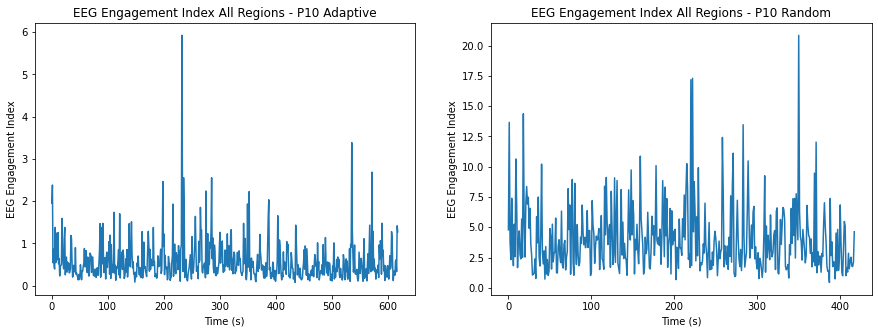

In [10]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(p10_adaptive['Total'])
plt.title('EEG Engagement Index All Regions - P10 Adaptive')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')

plt.subplot(1,2,2)
plt.plot(p10_random['Total'])
plt.title('EEG Engagement Index All Regions - P10 Random')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')


As can be seen in the two plots, the duration of the two conditions was different. 
Additionally, it can be seen that for this participant, the EEG engagement index in the Adaptive condition seemed to fluctuate between 0.5 and 6, which was lower and more narrow than in the Random condition (fluctuation between approx 2 and 20). It is possible that these differences were due to signal noise.

### Q1: The type of change seems to be **deterministic chaos / third order change**. 

# Section 2:  Is the signal stationary?

## Contents: 
- Variance testing
- Mean testing
- Autocorrelation testing
- KPSS Test
- Test for all participants

### 2.1 Stationarity Testing for P10 - Adaptive

#### Dividing the signal into two equal halves

In [13]:
length = len(p10_adaptive)

seq1 = p10_adaptive['Total'][0:length//2]
seq2 = p10_adaptive['Total'][length//2:]
print('Length first half: ', len(seq1))
print('Length second half: ', len(seq2))

Length first half:  309
Length second half:  309


In [21]:
#Testing for normality

from scipy.stats import shapiro
_, p_value1 = shapiro(seq1)
_, p_value2 = shapiro(seq2)



print("p-value seq 1:", p_value1)

print("p-value seq 2:", p_value2)

p-value seq 1: 2.3598737692084928e-23
p-value seq 2: 3.198204334909064e-20


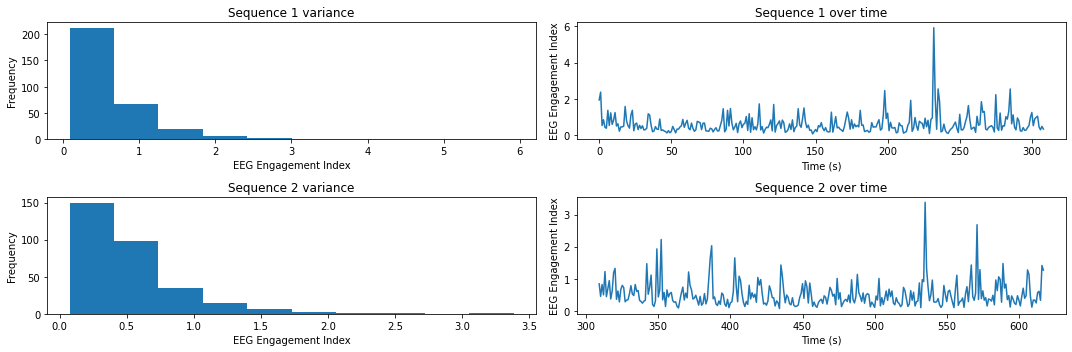

In [22]:
plt.figure(figsize = (15,5))

plt.subplot(2,2,1)
plt.hist(seq1)
plt.title('Sequence 1 variance')
plt.xlabel('EEG Engagement Index')
plt.ylabel('Frequency')

plt.subplot(2,2,2)
plt.plot(seq1)
plt.title('Sequence 1 over time')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')


plt.subplot(2,2,3)
plt.hist(seq2)
plt.title('Sequence 2 variance')
plt.xlabel('EEG Engagement Index')
plt.ylabel('Frequency')


plt.subplot(2,2,4)
plt.plot(seq2)
plt.title('Sequence 2 over time')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')

plt.tight_layout()

It looks like the distribution of the EEG Engagement Index is non-normal for both halves of the sequence.
For the purpose of approximating normality, we'll log transform the data for further testing. 


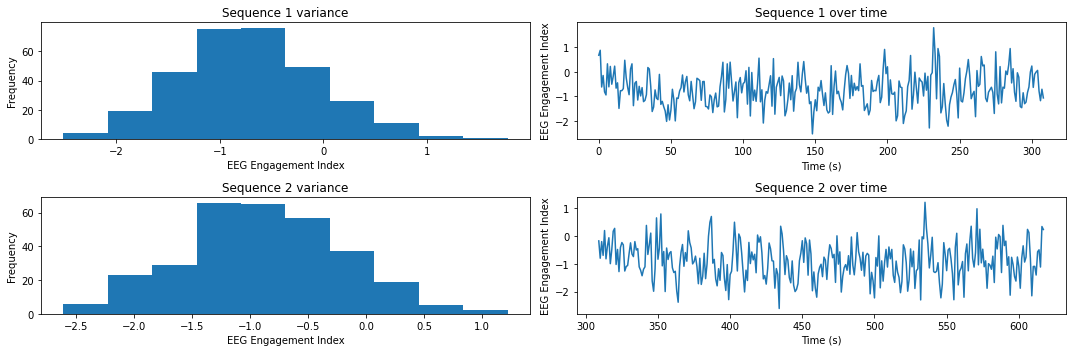

In [23]:
plt.figure(figsize = (15,5))



plt.subplot(2,2,1)
plt.hist(np.log(seq1))
plt.title('Sequence 1 variance')
plt.xlabel('EEG Engagement Index')
plt.ylabel('Frequency')

plt.subplot(2,2,2)
plt.plot(np.log(seq1))
plt.title('Sequence 1 over time')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')


plt.subplot(2,2,3)
plt.hist(np.log(seq2))
plt.title('Sequence 2 variance')
plt.xlabel('EEG Engagement Index')
plt.ylabel('Frequency')


plt.subplot(2,2,4)
plt.plot(np.log(seq2))
plt.title('Sequence 2 over time')
plt.xlabel('Time (s)')
plt.ylabel('EEG Engagement Index')

plt.tight_layout()

#### Variance / Levene Test (P10- Adaptive)


In [62]:
#Variance / Levene test
#Return True if variance is significantly different between the first and second half of the signals

from scipy.stats import levene

def testVariance(p, condition, region):
    participant = getParticipant(p, condition) 
    
    var = False 
    
    length = len(participant[region])

    seq1 = participant[region][0:length//2]
    seq2 = participant[region][length//2:]
    
    stat, p = levene(np.log(seq1), np.log(seq2))
    if p >= 0.05:  
        var = True
          
    elif p <= 0.05:
        var = False
            
    return p, var



In [98]:

print('Variance Adaptive seq1: ', np.std(seq1))
print('Variance Adaptive seq2: ', np.std(seq2))

p, var = testVariance(0, 'Adaptive', 'Total')
print('Levene test p value: ', p,';', 'Is the variance stationary? ', var)

Variance Adaptive seq1:  0.5394209138203775
Variance Adaptive seq2:  0.40539566241440456
Levene test p value:  0.94019675445253 ; Is the variance stationary?  True


From the levene test it seems that the variance between the two halves is not significant (p = 0.9401 )

####  Mean/ T-Test (P10- Adaptive)


In [74]:
#Mean / t-test 

def getMean(p, condition, region ):
    
    var = False
    direction = "No difference"
    
    participant = getParticipant(p, condition)
    length = len(participant[region])

    seq1 = participant[region][0:length//2]
    seq2 = participant[region][length//2:]
    
    pval, var = testVariance(p,condition, region)
    
    #Equal variance = True
    if var == True:
        stat, pval = stats.ttest_ind(a=np.log(seq1), b=np.log(seq2), equal_var=True)
              
    #Equal variance = false
    elif var == False:
        stat, pval = stats.ttest_ind(a=np.log(seq1), b=np.log(seq2), equal_var=False)
        

        
    if  (np.mean(np.log(seq1)) > np.mean(np.log(seq2))):
        direction = "Downward"
        
    elif (np.mean(seq1) < np.mean(seq2)):
        direction = "Upward"
        
    return pval,  direction #output includes a direction of change for the mean


In [75]:


print('Mean Adaptive seq1: ', np.mean(seq1))
print('Mean Adaptive seq2: ', np.mean(seq2))

pval,  direction = getMean(0, 'Adaptive', 'Total')

print( 'T-test p_value: ', p,';' ,'Direction of change: ', direction)

Mean Adaptive seq1:  0.6252999662745523
Mean Adaptive seq2:  0.5216949769369922
T-test p_value:  0.94019675445253 ; Direction of change:  Downward


From this result, it seems that the mean EEG Engagement Index does not significantly change between the two halves of the signal. 

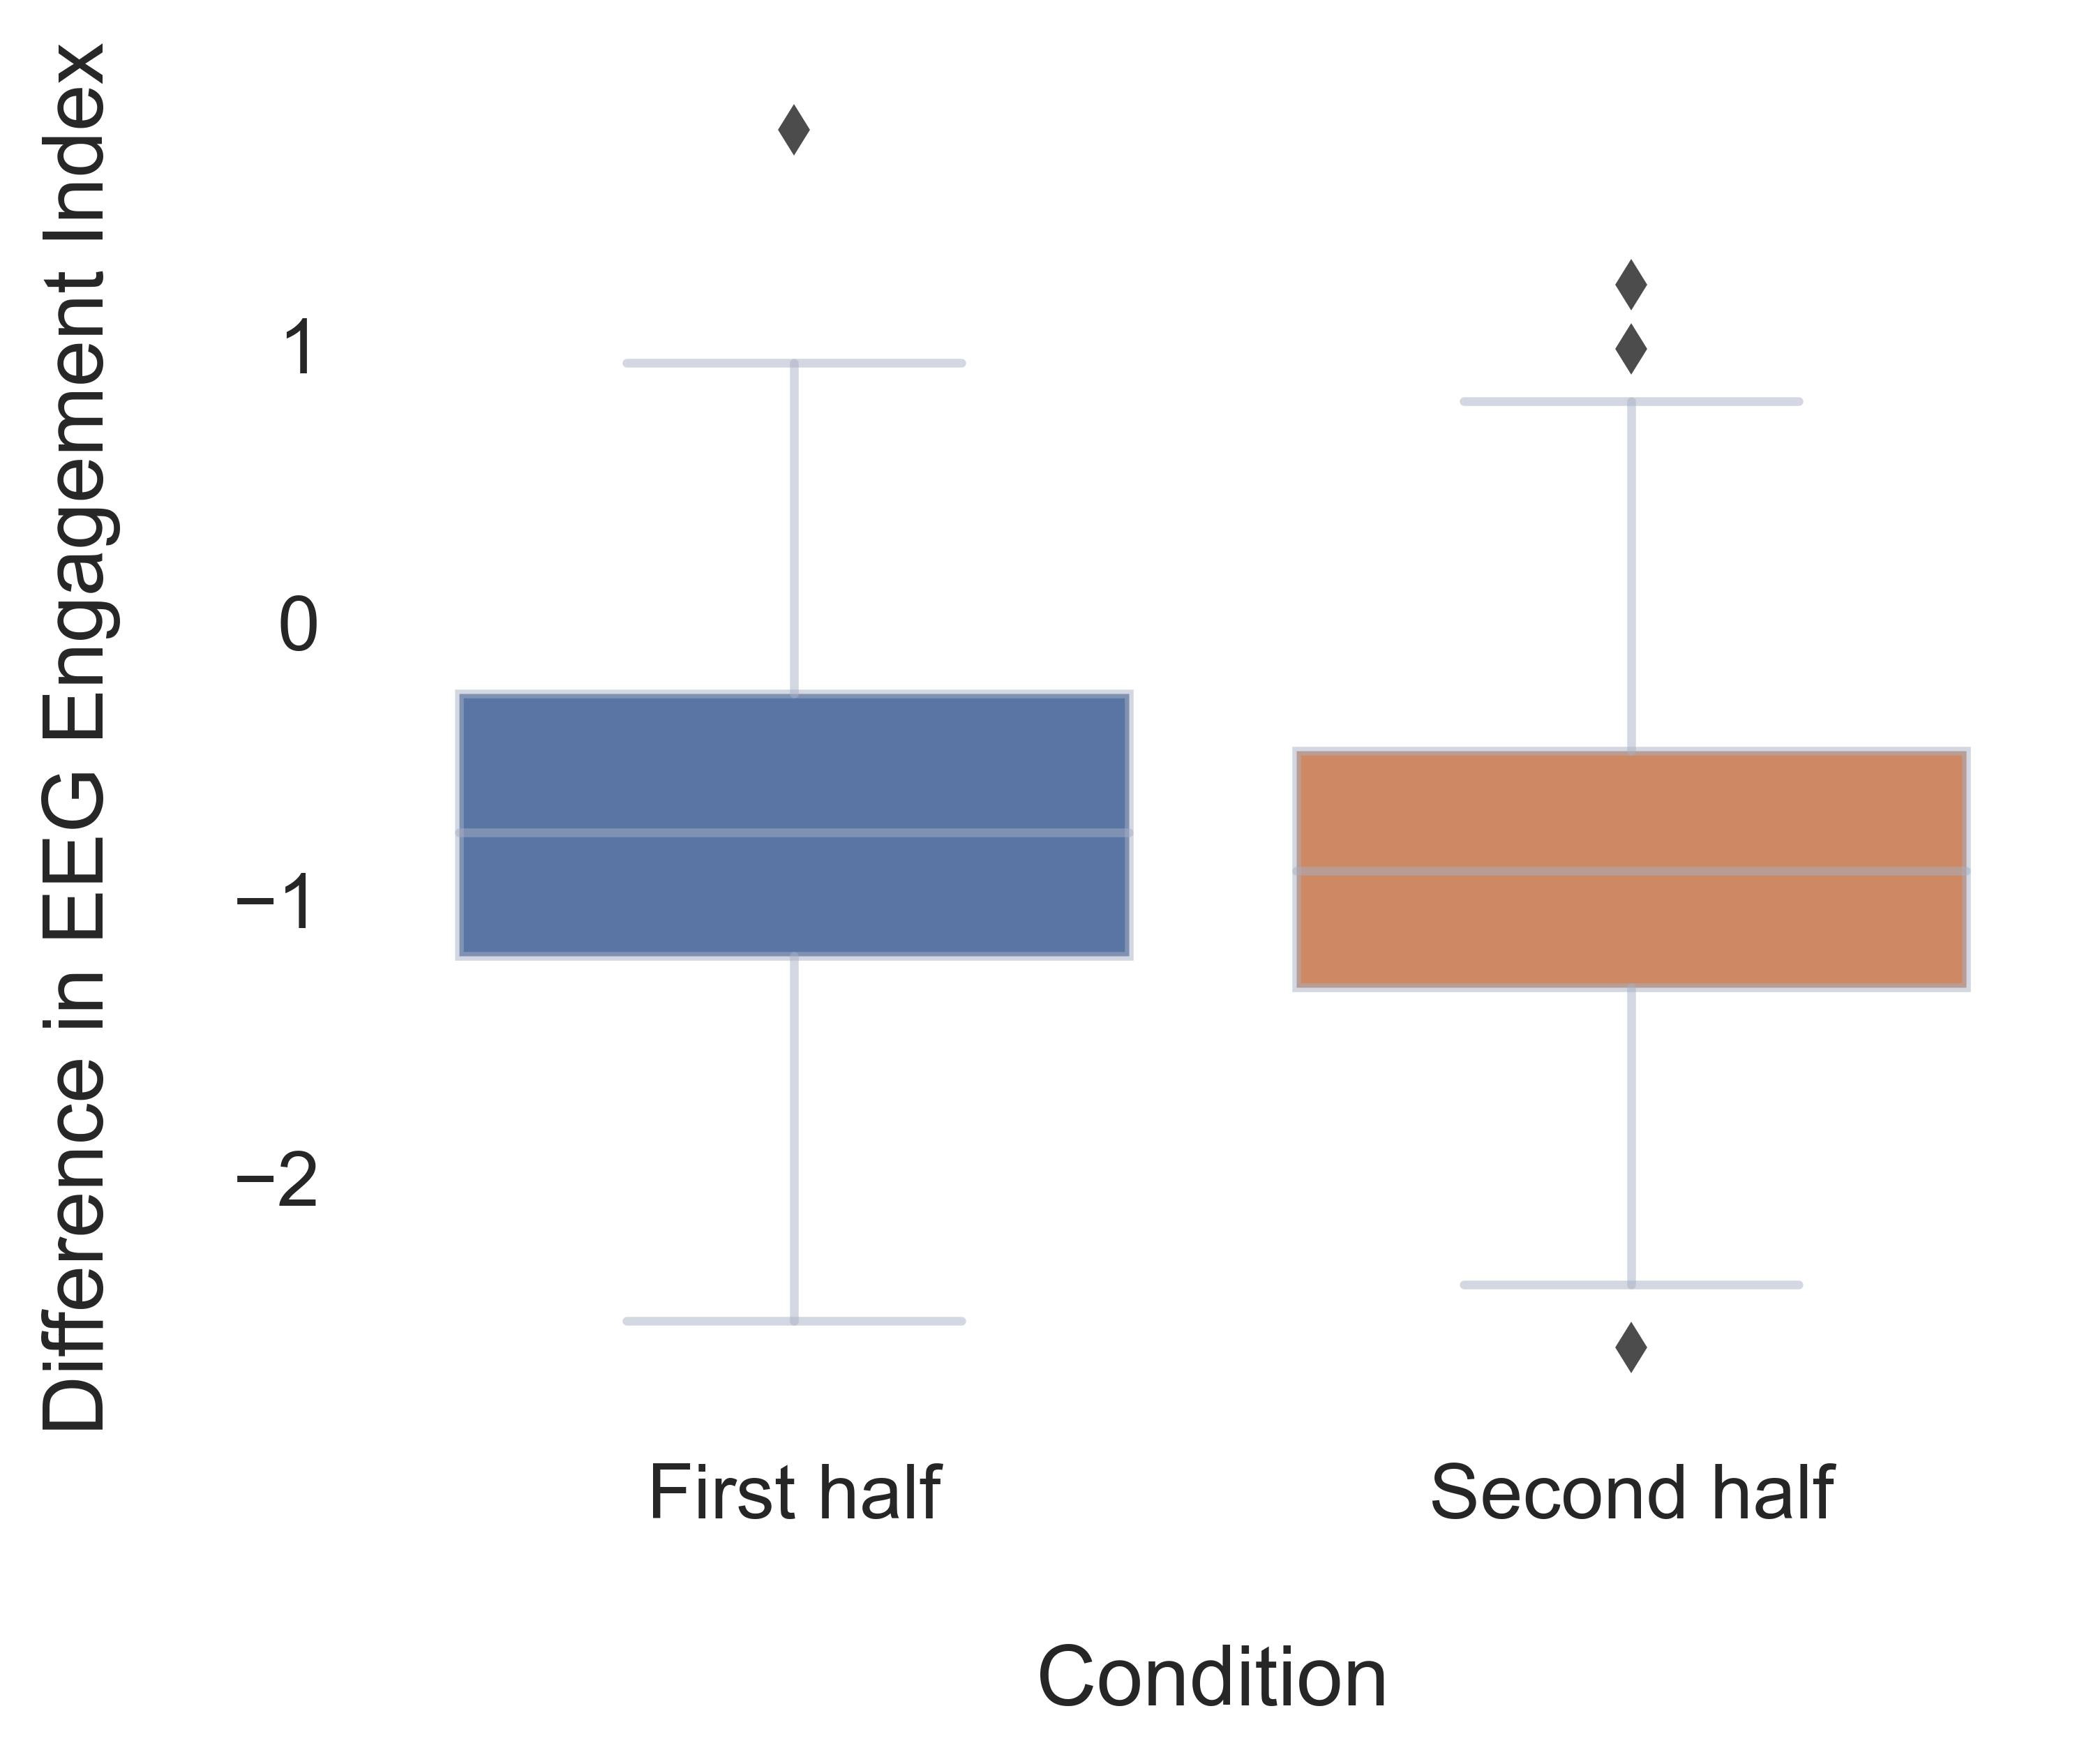

In [76]:
#This plot shows the difference of the EEG Engagement index over the first and second half of P10 - Adaptive

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="white", font_scale=1.2)

data = [np.log(seq1), np.log(seq2)]
labels = ['First half', 'Second half']

bcolor = '#A8B0C480'

plt.figure(dpi=600, figsize=(5, 4))

ax = sns.boxplot(data=data, boxprops=dict(edgecolor=bcolor),
            medianprops=dict(color=bcolor), whiskerprops=dict(color=bcolor), capprops=dict(color=bcolor))
ax.set_xticklabels(labels)


ax.set_xlabel('\nCondition')
ax.set_ylabel('Difference in EEG Engagement Index\n')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Display the plot
plt.show()

####  Checking autocorrelation (P10 - Adaptive)

Just as we did before with the variance and mean testing, the signal is divided into two halves. 

ACF and PACF plots were used to visualize autocorrelations in the two halves of the signal.

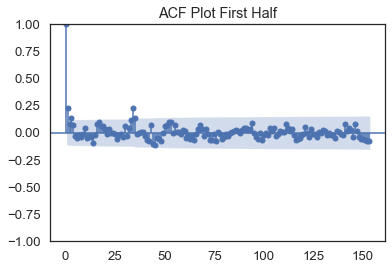

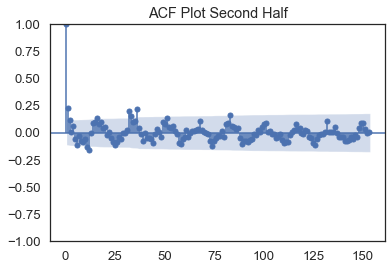

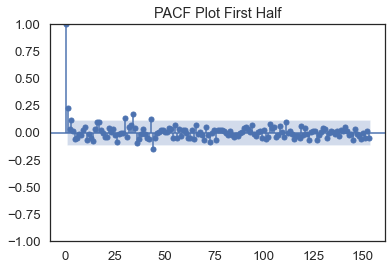

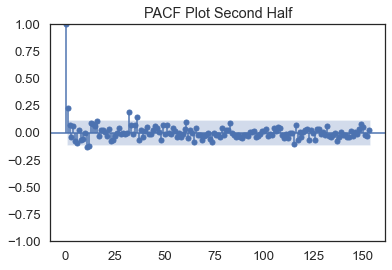

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa


maxlag = length//4-1 # Half of the signal, half of the sample

plot_acf(seq1, lags=maxlag);
plt.title('ACF Plot First Half')
plt.show()


plot_acf(seq2, lags=maxlag);
plt.title('ACF Plot Second Half')
plt.show()


plot_pacf(seq1, lags=maxlag, method='ywm')
plt.title('PACF Plot First Half')
plt.show()


plot_pacf(seq2, lags=maxlag, method='ywm')
plt.title('PACF Plot Second Half')
plt.show()




Interestingly, there seems to be a sinusoid patten in the ACF plot of the second half of P10- Adaptive. 
We can perform a fourier transform to see if there are any dominant frequencies we can extract. 

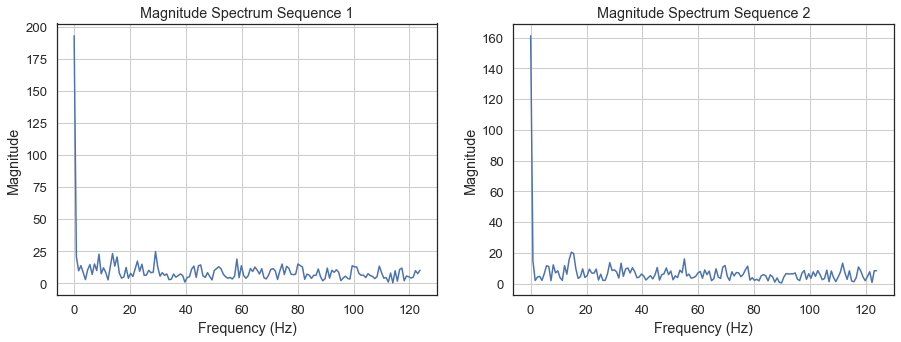

In [78]:
srate = 250
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)

X = np.fft.fft(seq1)
magnitudes = np.abs(X)
frequencies = np.fft.fftfreq(len(seq1), d=1/srate) 
plt.plot(frequencies[:len(frequencies)//2], magnitudes[:len(magnitudes)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum Sequence 1')
plt.grid(True)

plt.subplot(1,2,2)

X = np.fft.fft(seq2)
magnitudes = np.abs(X)
frequencies = np.fft.fftfreq(len(seq2), d=1/srate)
plt.plot(frequencies[:len(frequencies)//2], magnitudes[:len(magnitudes)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum Sequence 2')
plt.grid(True)


From the magnitude plots it seems that the **most periodicity can be found at very small lag values around 1**.  
Another way to try and find periodicity is by getting any significant peaks from ACF which we will do next. 

In [79]:
#The following code calculates whether there are any significant peaks in the ACF
#We divide the signal into two halves once more to see if anything is different between the detected peaks

from statsmodels.tsa import stattools
def getPeaks(p, condition, region):
    
    
    participant = getParticipant(p, condition) 
    length = len(participant[region])

    seq1 = participant[region][0:length//2]
    seq2 = participant[region][length//2:]
    
    peaklist1 = []  
    peaklist2 = []  
    
    autocorr_1 = tsa.acf(seq1, nlags = length//2)   #capping the lags at 1/4th of the full condition
    autocorr_2 = tsa.acf(seq2, nlags = length//2) 
    
    acf_significant_1 = (np.abs(autocorr_1[1:]) > (1.96 / np.sqrt(len(seq1)))) #Significance set at 0.05
    acf_lags_1 = np.where(acf_significant_1)[0] + 1
    
    acf_significant_2 = (np.abs(autocorr_2[1:]) > (1.96 / np.sqrt(len(seq2))))
    acf_lags_2 = np.where(acf_significant_2)[0] + 1
    
    peaklist1.append(acf_lags_1) 
    peaklist1 = np.array(peaklist1)
    
    peaklist2.append(acf_lags_2) 
    peaklist2 = np.array(peaklist2)
    
    return peaklist1.flatten(), peaklist2.flatten()

s1, s2 = getPeaks(0,'Adaptive', 'Total')

print('Significant lag peaks - First Half: ', s1 )
print('Significant lag peaks - Second Half: ', s2)

print('Significant lag - P10 Adaptive Overall: ', np.concatenate((s1, s2), axis=0))


Significant lag peaks - First Half:  [ 1  3 33 34 35 45]
Significant lag peaks - Second Half:  [  1   2  11  12  16  25  32  33  36  51  74  83 126 174 186]
Significant lag - P10 Adaptive Overall:  [  1   3  33  34  35  45   1   2  11  12  16  25  32  33  36  51  74  83
 126 174 186]


The **significant lag peaks seem to occur mostly at 1-3 lags for both halves of the signal. This aligns with the magnitude plots we made before, which show large peaks at around 1-3 Hz as well.** 
However, in the second half, it seems that there are some more significant peaks at higher lag values.
We can visualize this in some histograms.

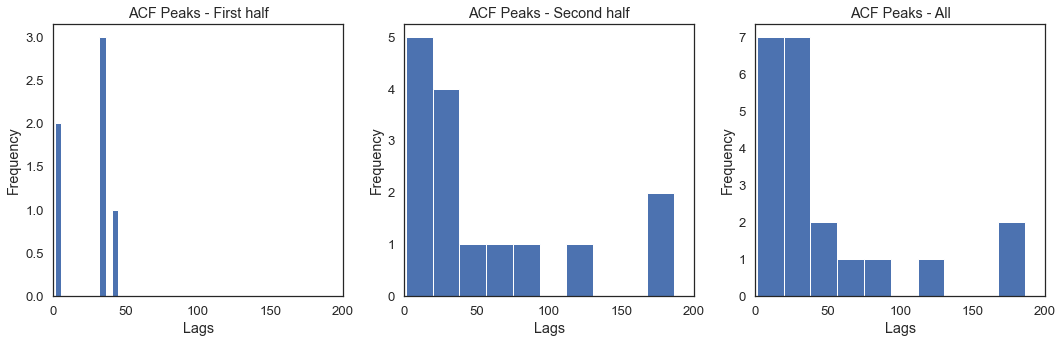

In [80]:
plt.figure( figsize = (15, 5))

plt.subplot(1,3,1)
plt.hist(s1)
plt.title('ACF Peaks - First half')
plt.xlabel('Lags')
plt.ylabel('Frequency')
plt.xlim(0,200)

plt.subplot(1,3,2)
plt.hist(s2)
plt.title('ACF Peaks - Second half')
plt.xlabel('Lags')
plt.ylabel('Frequency')
plt.xlim(0,200)

plt.subplot(1,3,3)
plt.hist(np.concatenate((s1, s2), axis=0))
plt.title('ACF Peaks - All')
plt.xlabel('Lags')
plt.ylabel('Frequency')
plt.xlim(0,200)

plt.tight_layout()

- The significant ACF peaks seem to be **different in the second half compared to the first half**.
- Specifically, it looks like the **significant lag peaks take higher values in the second half of the signal**. 
- This indicates that, at least for participant 10,  the temporal signature of the EEG Engagement Index changed over time in the adaptive condition. 

#### KPSS Test (P10 - Adaptive)

The following code snippet calculates the KPSS test statistic for stationarity (participant 10, Random Condition ).
It returns True if the signal is stationary, (determined by the p-value being smaller than 0.05). 

In [81]:

from statsmodels.tsa.stattools import kpss


def testStationarity(p, condition, region):
    participant = getParticipant(p, condition)
    
    stat, p_value, _, _ = kpss(participant[region])
    
    if p_value <= 0.05:  
        var = False
    else:
        var = True
            
    return p_value, stat, var


p, stat, var = testStationarity(0, 'Adaptive', 'Total')
print("p-value:", p)

print("KPSS Statistic:", stat)
print("Stationary:", var)


p-value: 0.09268447165159516
KPSS Statistic: 0.36397202576829923
Stationary: True


This signal (P10- Adaptive) seems to be stationary due to the **non-significant outcome of the KPSS test**. (p = 0.0926) 

### 2.2 Stationarity Testing Random Condition

In this section, we will calculate stationarity of the following variables for all signals in both conditions. 

Essentially, this will be done in the same way as outlined above with P10 - Adaptive. 
- Check variance
- Check mean
- Get significant autocorrelation peaks
- Check KPSS statistic


In [99]:
#This code block generates the dataframes containing relevant information about stationarity and ACF peaks in both conditions

import warnings
warnings.filterwarnings("ignore")

conditions = ['Random', 'Adaptive']
regions = ['Total', 'Frontal', 'Central', 'Parietal']
random_dfs = []
adaptive_dfs = []

def getDF(condition, region):
    stats = []
    pvals = []
    bools = []
    direction = []
    variances_p = []
    means_p = []
    autocorrs1 = []
    autocorrs2 = []
    
    for i in range(len(flistRandom)):
        p, stat, var = testStationarity(i, condition, region)
        stats.append(stat)
        pvals.append(p)
        bools.append(var)
        
        var_p, var_bool = testVariance(i, condition, region)
        
        
        variances_p.append(var_p)
        
        mean_p,  direct = getMean(i, condition, region)
        
        means_p.append(mean_p)
        direction.append(direct)
        
        a1, a2 = getPeaks(i, condition, region)
        
        autocorrs1.append(a1)
        autocorrs2.append(a2)
          
    
    df_out = pd.DataFrame({
        'Participant': flistRandom,
        
        'Levene_p': variances_p,
        
        'Ttest_p': means_p,
        'KPSS Value': stats,
        'KPSS_p': pvals,
        'KPSS_Stationary' : bools, 
        'MeanDirection': direction,
        
        'ACF_FirstHalf' : autocorrs1, 
        'ACF_SecondHalf' : autocorrs2
    })
    
    return df_out

for condition in conditions:
    for region in regions: 
        if condition == 'Random':
            random_dfs.append(getDF(condition, region))
            
        elif condition == 'Adaptive':
            adaptive_dfs.append(getDF(condition, region))



In [89]:
#regions = ['Total', 'Frontal', 'Central', 'Parietal']

random_dfs[0].head(5) #Statistics for Random condition, Total Region

,Participant,Levene_p,Ttest_p,KPSS Value,KPSS_p,KPSS_Stationary,MeanDirection,ACF_FirstHalf,ACF_SecondHalf
0,P10Engagement_1sec.csv,0.218276,0.126191,0.264644,0.10,True,Downward,"[7, 17, 71]","[2, 7, 16, 130]"
1,P11Engagement_1sec.csv,0.601199,0.466379,0.115132,0.10,True,Upward,"[1, 52, 74, 91]","[2, 5, 40, 51, 70, 116]"
2,P12Engagement_1sec.csv,0.660891,0.594301,0.088620,0.10,True,Upward,[6],"[10, 28, 71, 82]"
3,P13Engagement_1sec.csv,0.632498,0.207317,0.081047,0.10,True,Downward,"[2, 14, 16, 31, 34, 43, 45]","[9, 47, 50, 69]"
4,P14Engagement_1sec.csv,0.717288,0.000329,0.851761,0.01,False,Upward,"[18, 24, 31, 38, 69, 149]","[2, 26, 48, 98]"


In [90]:
condition = 'Random'
print("{}/39 timeseries in the {} Condition in the Total region were stationary!".format(sum(random_dfs[0]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Frontal region were stationary!".format(sum(random_dfs[1]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Central region were stationary!".format(sum(random_dfs[2]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Parietal region were stationary!".format(sum(random_dfs[3]['KPSS_Stationary']), condition ))


28/39 timeseries in the Random Condition in the Total region were stationary!
29/39 timeseries in the Random Condition in the Frontal region were stationary!
27/39 timeseries in the Random Condition in the Central region were stationary!
29/39 timeseries in the Random Condition in the Parietal region were stationary!


### Q2: Are the signals stationary? (Random Condition)
- It seems that **for most participants**, during the random condition, the **EEG engagement index was stationary** in certain regions
- While there do seem to be some regional differences, it **does not look like any region in particular showed nonstationarity in the EEG Engagement Index**

### 2.3 Stationarity Testing Adaptive Condition

In [91]:

print("{}/39 timeseries in the {} Condition in the Total region were stationary!".format(sum(adaptive_dfs[0]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Frontal region were stationary!".format(sum(adaptive_dfs[1]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Central region were stationary!".format(sum(adaptive_dfs[2]['KPSS_Stationary']), condition ))
print("{}/39 timeseries in the {} Condition in the Parietal region were stationary!".format(sum(adaptive_dfs[3]['KPSS_Stationary']), condition ))


25/39 timeseries in the Random Condition in the Total region were stationary!
25/39 timeseries in the Random Condition in the Frontal region were stationary!
26/39 timeseries in the Random Condition in the Central region were stationary!
29/39 timeseries in the Random Condition in the Parietal region were stationary!


### Q2: Are the signals stationary? (Adaptive Condition)
- It seems that similarly to the Random Condition, the **EEG Engagement in the Adaptive condition was not always stationary**
- In the Adaptive Condition, it seems that **nonstationarity was more prevalent than in the Random Condition**

- Particularly in the **total, frontal and central regions** most nonstationarity was observed 

# Section 3: Do Autocorrelation peaks change over time?

In section 2 we found that for participant P10 in the Adaptive condition, the autocorrelation plot for the EEG Engagement Index became more sinusoidal in the second half of the signal. Additionally, we found that the distribution of significant ACF peaks was different between the first and second half of the signal. In this section, we will try to see if this was a one time occurence or maybe more participants show this pattern in their EEG Engagement Index.  

## 3.1 Random condition

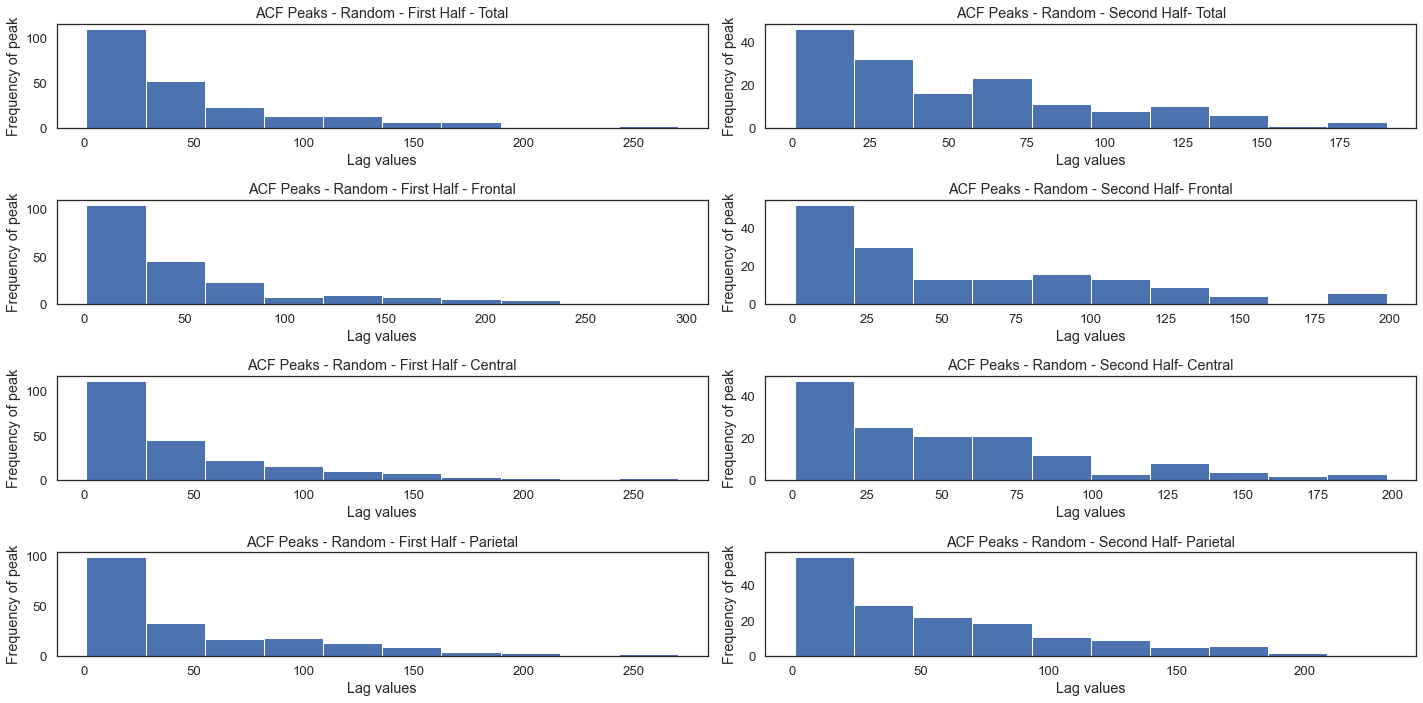

In [94]:
plt.figure(figsize = (20,10))

plt.subplot(4,2,1)

##Total Region

sample1 = np.array([i for i in random_dfs[0]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
plt.title('ACF Peaks - Random - First Half - Total')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,2)
sample2 = np.array([i for i in random_dfs[0]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
    
plt.title('ACF Peaks - Random - Second Half- Total')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

##Frontal Region

plt.subplot(4,2,3)
sample1 = np.array([i for i in random_dfs[1]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Random - First Half - Frontal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,4)
sample2 = np.array([i for i in random_dfs[1]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
plt.title('ACF Peaks - Random - Second Half- Frontal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

##Central Region

plt.subplot(4,2,5)
sample1 = np.array([i for i in random_dfs[2]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Random - First Half - Central')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,6)
sample2 = np.array([i for i in random_dfs[2]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
plt.title('ACF Peaks - Random - Second Half- Central')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

## Parietal Region

plt.subplot(4,2,7)
sample1 = np.array([i for i in random_dfs[3]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Random - First Half - Parietal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,8)
sample2 = np.array([i for i in random_dfs[3]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);

plt.title('ACF Peaks - Random - Second Half- Parietal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')


plt.tight_layout()

### Q3: Does autocorrelation as calculated by ACF change over time? (Random Condition)

These histograms show the distribution of significant ACF lag peaks between the first and second halves of the timeseries.  

It looks like in every region, the ACF peaks of the EEG Engagement Index become more evenly distributed towards the second half of the signal.  From these histrograms, it may be interpreted that the temporal dynamics of the EEG Engagement Index change over time.

It may be interesting for a followup analysis to look into stationarity and autorecurrence within specific frequency bands that compose the EEG Engagement Index (alpha, beta and theta) to be able to make a more clear judgement on the change in the signals reflected here.  


## 3.2 Adaptive condition

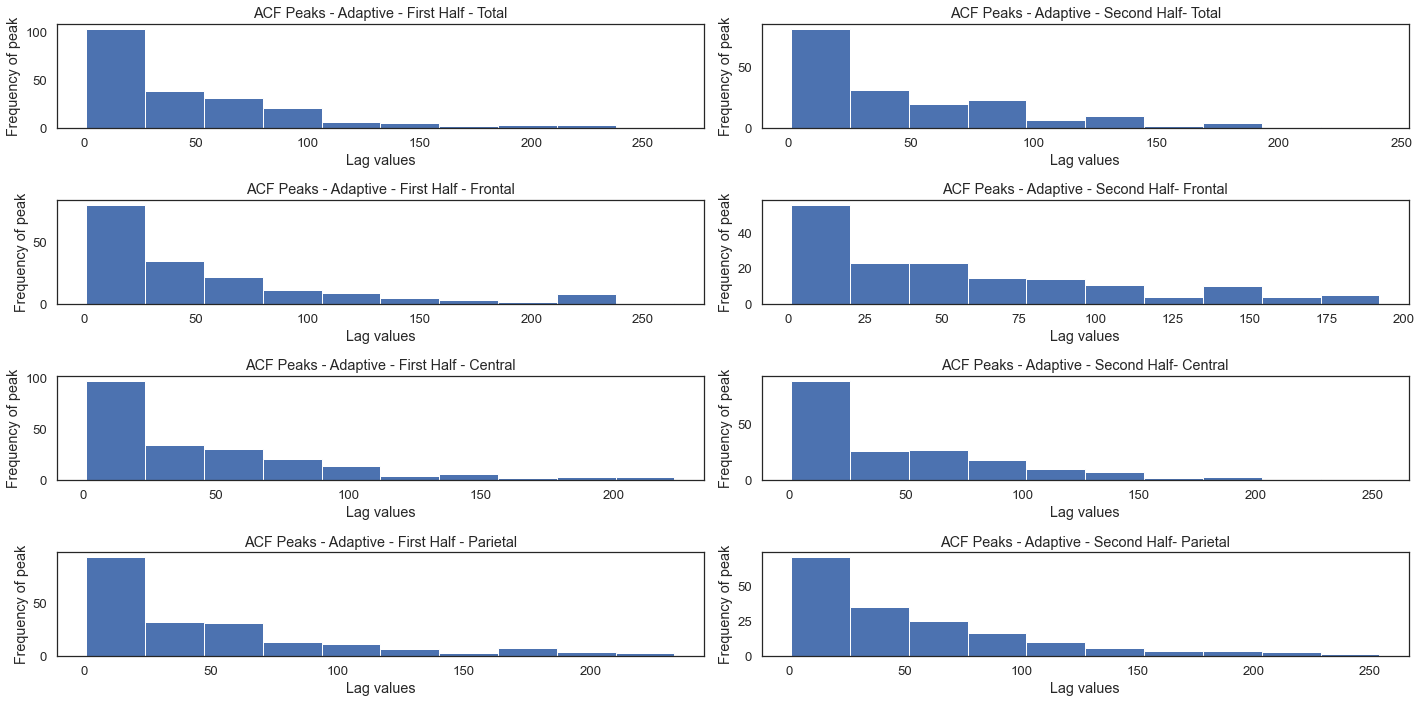

In [93]:
plt.figure(figsize = (20,10))

plt.subplot(4,2,1)

##Total Region

sample1 = np.array([i for i in adaptive_dfs[0]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
plt.title('ACF Peaks - Adaptive - First Half - Total')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,2)
sample2 = np.array([i for i in adaptive_dfs[0]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
    
plt.title('ACF Peaks - Adaptive - Second Half- Total')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

##Frontal Region

plt.subplot(4,2,3)
sample1 = np.array([i for i in adaptive_dfs[1]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Adaptive - First Half - Frontal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,4)
sample2 = np.array([i for i in adaptive_dfs[1]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
plt.title('ACF Peaks - Adaptive - Second Half- Frontal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

##Central Region

plt.subplot(4,2,5)
sample1 = np.array([i for i in adaptive_dfs[2]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Adaptive - First Half - Central')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,6)
sample2 = np.array([i for i in adaptive_dfs[2]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);
    
plt.title('ACF Peaks - Adaptive - Second Half- Central')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

## Parietal Region

plt.subplot(4,2,7)
sample1 = np.array([i for i in adaptive_dfs[3]['ACF_FirstHalf']])
s1_flat = np.concatenate(sample1).flatten()
plt.hist(s1_flat);
    
    
plt.title('ACF Peaks - Adaptive - First Half - Parietal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')

plt.subplot(4,2,8)
sample2 = np.array([i for i in adaptive_dfs[3]['ACF_SecondHalf']])
s2_flat = np.concatenate(sample2).flatten()
plt.hist(s2_flat);

plt.title('ACF Peaks - Adaptive - Second Half- Parietal')
plt.xlabel('Lag values')
plt.ylabel('Frequency of peak')


plt.tight_layout()


### Q3: Does autocorrelation as calculated by ACF change over time? (Adaptive Condition)
Similarly to the random condition, it looks like the ACF peak histograms become more evenly distributed in the second half of the signals. 


